### Approximating the Lorenz attractor with Nonlinear Vector Autoregression (NVAR)

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
import warnings
from IPython.display import clear_output, display
import sympy as sp
import copy

from NVAR import *
from utils import RMSE

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [102]:
def get_symbolic_state_labels(k, d, nonlinearFunc=None, extraNonlinearFunc=None):
    bias = np.array([sp.symbols("1")])
    lin_entries = []
    for i in range(k):
        for j in range(d):
            if i == 0:
                lin_entries.append(sp.symbols(f'x(t)_{j+1}'))
            elif i == 1:
                lin_entries.append(sp.symbols(f'x(t-s)_{j+1}'))
            else:
                lin_entries.append(sp.symbols(f'x(t-{i}s)_{j+1}'))
    linarray = np.array(lin_entries)
    lin = np.reshape(linarray, (linarray.shape[0],1))
    zipped = []
    if nonlinearFunc != None and extraNonlinearFunc != None:
        nonlin = nonlinearFunc(lin)
        extranonlin = extraNonlinearFunc(np.vstack([lin, nonlin]))
        arr = np.vstack(
            [
                1,
                lin,
                nonlin,
                extranonlin
            ]
        )
        for i in range(len(arr)):
            if i < 1:
                zipped.append([arr[i,0], 'bias'])
            elif i < 1 + len(lin):
                zipped.append([arr[i,0], 'linear']) 
            elif i < 1 + len(lin) + len(nonlin):
                zipped.append([arr[i,0], 'nonlinear'])
            elif i < 1 + len(lin) + len(nonlin) + len(extranonlin):
                zipped.append([arr[i,0], 'extra-nonlinear'])
        zipped = np.array(zipped)
        return zipped
    elif nonlinearFunc != None:
        nonlin = nonlinearFunc(lin)
        arr = np.vstack(
            [
                1,
                lin,
                nonlin
            ]
        )
        for i in range(len(arr)):
            if i < 1:
                zipped.append([arr[i,0], 'bias'])
            elif i < 1 + len(lin):
                zipped.append([arr[i,0], 'linear']) 
            elif i < 1 + len(lin) + len(nonlin):
                zipped.append([arr[i,0], 'nonlinear'])
        zipped = np.array(zipped)
        return zipped
    else:
        arr = np.vstack(
            [
                1,
                lin
            ]
        )
        for i in range(len(arr)):
            if i < 1:
                zipped.append([arr[i,0], 'bias'])
            elif i < 1 + len(lin):
                zipped.append([arr[i,0], 'linear'])
        zipped = np.array(zipped)
        return zipped

def get_norm_df(symb_state_arr, model):
    dim = model.w.shape[1]
    dict_list = []
    for i in range(dim):
        d = {x : np.linalg.norm(model.w[symb_state_arr[:,1] == x,i])**2 for x in np.unique(symb_state_arr[:,1])}
        d['total'] = np.linalg.norm(model.w[:,i])**2
        dict_list.append(d.copy())
    d = {x : np.linalg.norm(model.w[symb_state_arr[:,1] == x,:])**2 for x in np.unique(symb_state_arr[:,1])}
    d['total'] = np.linalg.norm(model.w)**2
    dict_list.append(d)
    df = pd.DataFrame(
        dict_list,
        index = [f'x_{i+1}' for i in range(dim)] + ['total'],
        # index = ['total', 'x_1', 'x_2', 'x_3'],
        columns=list(np.unique(symb_state_arr[:,1])) + ['total']
        ).transpose()
    return df

In [113]:
T = 100
dt = 0.01

lorenz = np.loadtxt(f'./datasets/py-lorenz_RK4_T={T}_dt={dt}.csv', delimiter=",", dtype='float64')

# c = 1/50
# feature_mean = lorenz[:,1:].mean(axis=0)
# target_mean = lorenz[1:,1:].mean(axis=0)

raw_data = lorenz[:,1:]
raw_target = lorenz[1:,1:]

data = raw_data
target = raw_target

# data = np.tanh((lorenz[:,1:]-feature_mean)*c)
# target = np.tanh((lorenz[1:,1:]-target_mean)*c)

k=4
# k=8
# k=12
# k=16

train_start=500
train_end=8000
test_start=train_end
test_end=10000

training_target = target[train_start:train_end]
test_target = target[test_start:]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [92]:
model_arr = []
s_grid = [2,3,4,5,6,7,8,10]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
recursive_rmse_arr = []
ctr = 0
total_scens = len(s_grid)*len(reg_grid)
for s in s_grid:
    for r in reg_grid:
        clear_output(wait=True)
        print(f'done: scen {ctr}/{total_scens-1} ({100*ctr/(total_scens-1):.02f}%) |  s={s} r={r}')
        model = NVARModel(k, s, r, quadraticCombination)
        model.train(data, target, train_indices)
        recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        model_arr.append(model)
        ctr += 1
recursive_rmse_arr = np.array(recursive_rmse_arr)
best_recursive_idx = np.argmin(recursive_rmse_arr[~np.isnan(recursive_rmse_arr)])
best_recursive_model = [model_arr[i] for i in range(len(model_arr)) if ~np.isnan(recursive_rmse_arr)[i]][best_recursive_idx]

print(f'best recursive params (quadratic model) T={T}')
print(f'k  :{best_recursive_model.k}')
print(f's  :{best_recursive_model.s}')
print(f'reg:{best_recursive_model.reg}')

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params (quadratic model) T=100
k  :4
s  :4
reg:1e-05


In [93]:
nvar_rows(3, 4), nvar_rows(3, 8), nvar_rows(3, 12), nvar_rows(3, 16)

(91, 325, 703, 1225)

In [114]:
quadratic_model_100 = NVARModel(k=4, s=4, reg=1e-5, nonlinearFunc=quadraticCombination) # k=4
# quadratic_model_100 = NVARModel(k=8, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=8
# quadratic_model_100 = NVARModel(k=12, s=4, reg=1e-6, nonlinearFunc=quadraticCombination) # k=12
# quadratic_model_100 = NVARModel(k=16, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=16
quadratic_model_100.train(data, target, train_indices)
quadratic_model_100.evaluate(data, target, test_indices)

2.203117739348266e-05

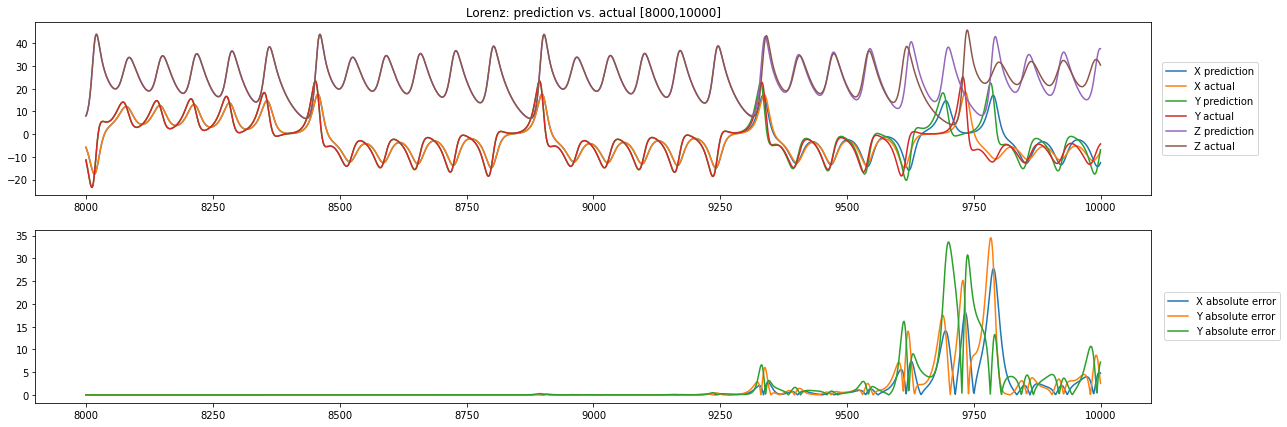

In [115]:
# recursive_out = (np.arctanh(lor_best_recursive_model.recursive_predict(data, train_start, train_end, test_end-test_start))/c+target_mean)
recursive_out = quadratic_model_100.recursive_predict(data, train_start, train_end, test_end-test_start)
data_end = train_end
# t_forward = test_end-test_start
t_forward = 2000

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,0]-raw_data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,1]-raw_data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,2]-raw_data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

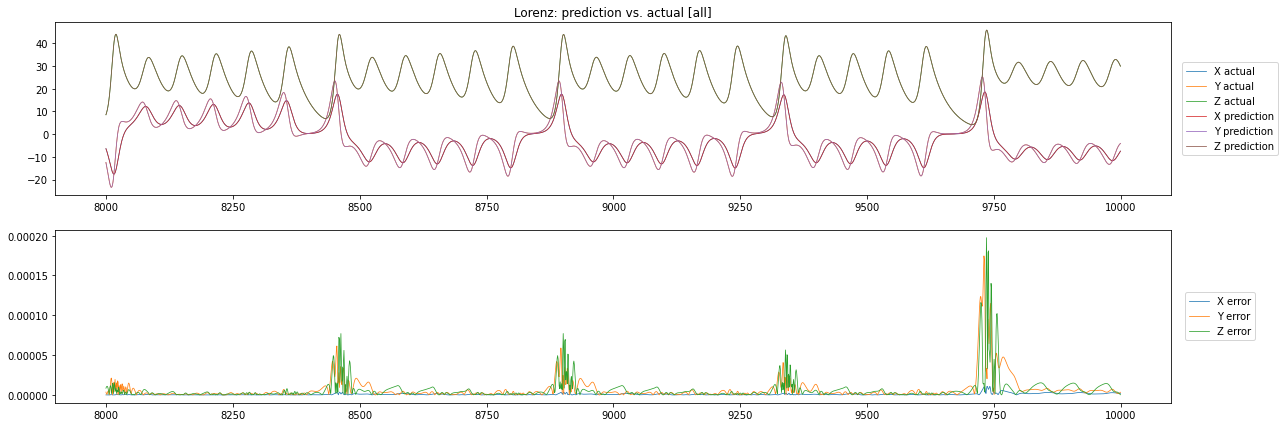

In [116]:
test_out = quadratic_model_100.test_out

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], linewidth=0.75, label="X actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], linewidth=0.75, label="Y actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], linewidth=0.75, label="Z actual")
axs[0].plot(np.arange(test_start,test_end), test_out[:,0], linewidth=0.75, label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,1], linewidth=0.75, label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,2], linewidth=0.75, label="Z prediction")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,0]-test_target[:,0]), linewidth=0.75, label="X error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,1]-test_target[:,1]), linewidth=0.75, label="Y error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,2]-test_target[:,2]), linewidth=0.75, label="Z error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.08,0.5))
axs[0].set_title('Lorenz: prediction vs. actual [all]')
plt.subplots_adjust(hspace=0.2)
plt.show()

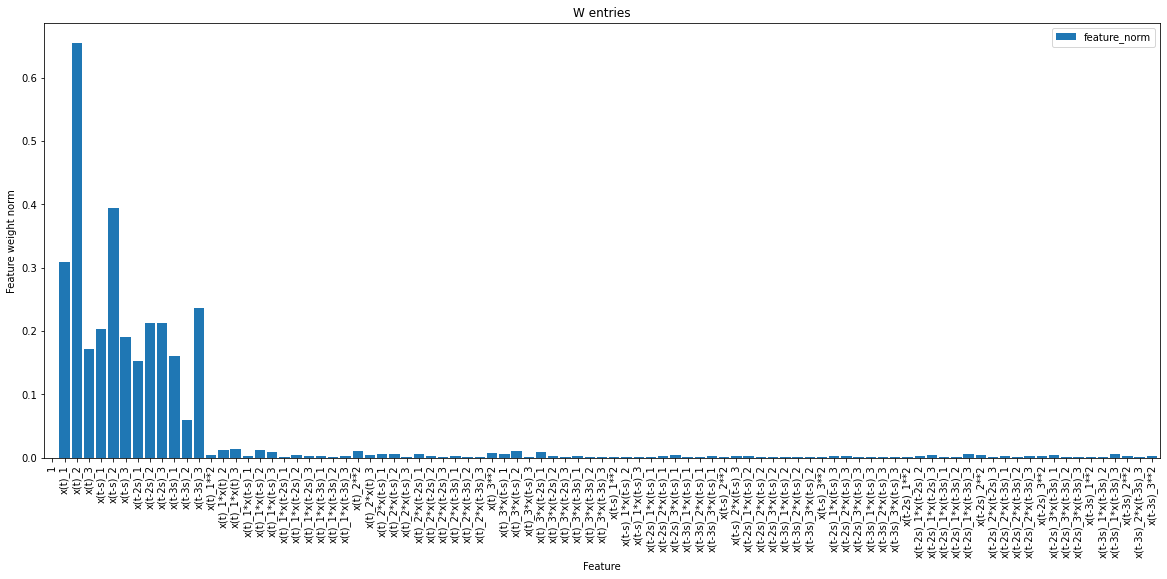

In [117]:
symb_state = get_symbolic_state_labels(
    k=4,
    d=3,
    nonlinearFunc = quadraticCombination,
    extraNonlinearFunc = None
)
df = pd.DataFrame(quadratic_model_100.w, columns=['x_1','x_2','x_3'])
df['feature'] = symb_state[:,0]
df['feature_type'] = symb_state[:,1]

feature_norms = np.array([np.linalg.norm(x) for x in quadratic_model_100.w])
df_combined = pd.DataFrame(feature_norms, columns=['feature_norm'])
df_combined['feature'] = symb_state[:,0]
df_combined['feature_type'] = symb_state[:,1]

ax = df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Feature weight norm',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df_combined['feature'])
ax.legend()

In [118]:
T = 300
dt = 0.01

lorenz = np.loadtxt(f'./datasets/py-lorenz_RK4_T={T}_dt={dt}.csv', delimiter=",", dtype='float64')

# c = 1/50
# feature_mean = lorenz[:,1:].mean(axis=0)
# target_mean = lorenz[1:,1:].mean(axis=0)

raw_data = lorenz[:,1:]
raw_target = lorenz[1:,1:]

data = raw_data
target = raw_target

# data = np.tanh((lorenz[:,1:]-feature_mean)*c)
# target = np.tanh((lorenz[1:,1:]-target_mean)*c)

k=4
# k=8
# k=12
# k=16

train_start=500
train_end=24000
test_start=train_end
test_end=30000

training_target = target[train_start:train_end]
test_target = target[test_start:]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [98]:
model_arr = []
s_grid = [2,3,4,5,6,7,8,10]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
recursive_rmse_arr = []
ctr = 0
total_scens = len(s_grid)*len(reg_grid)
for s in s_grid:
    for r in reg_grid:
        clear_output(wait=True)
        print(f'done: scen {ctr}/{total_scens-1} ({100*ctr/(total_scens-1):.02f}%) |  s={s} r={r}')
        model = NVARModel(k, s, r, quadraticCombination)
        model.train(data, target, train_indices)
        recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        model_arr.append(model)
        ctr += 1
recursive_rmse_arr = np.array(recursive_rmse_arr)
best_recursive_idx = np.argmin(recursive_rmse_arr[~np.isnan(recursive_rmse_arr)])
best_recursive_model = [model_arr[i] for i in range(len(model_arr)) if ~np.isnan(recursive_rmse_arr)[i]][best_recursive_idx]

print(f'best recursive params (quadratic model) T={T}')
print(f'k  :{best_recursive_model.k}')
print(f's  :{best_recursive_model.s}')
print(f'reg:{best_recursive_model.reg}')

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params (quadratic model) T=300
k  :4
s  :5
reg:0.001


In [119]:
quadratic_model_300 = NVARModel(k=4, s=5, reg=0.001, nonlinearFunc=quadraticCombination) # k=4
# quadratic_model_300 = NVARModel(k=8, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=8 TBC
# quadratic_model_300 = NVARModel(k=12, s=4, reg=1e-6, nonlinearFunc=quadraticCombination) # k=12 TBC
# quadratic_model_300 = NVARModel(k=16, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=16 TBC
quadratic_model_300.train(data, target, train_indices)
quadratic_model_300.evaluate(data, target, test_indices)

1.0133319465406709e-05

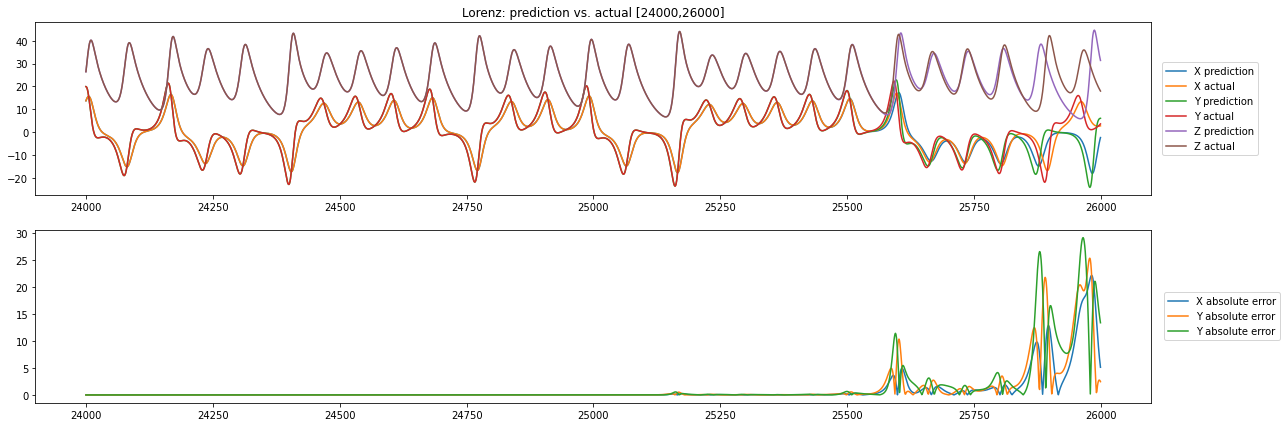

In [123]:
recursive_out = quadratic_model_300.recursive_predict(data, train_start, train_end, test_end-test_start)
data_end = train_end
# t_forward = test_end-test_start
t_forward = 2000

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,0]-raw_data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,1]-raw_data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,2]-raw_data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

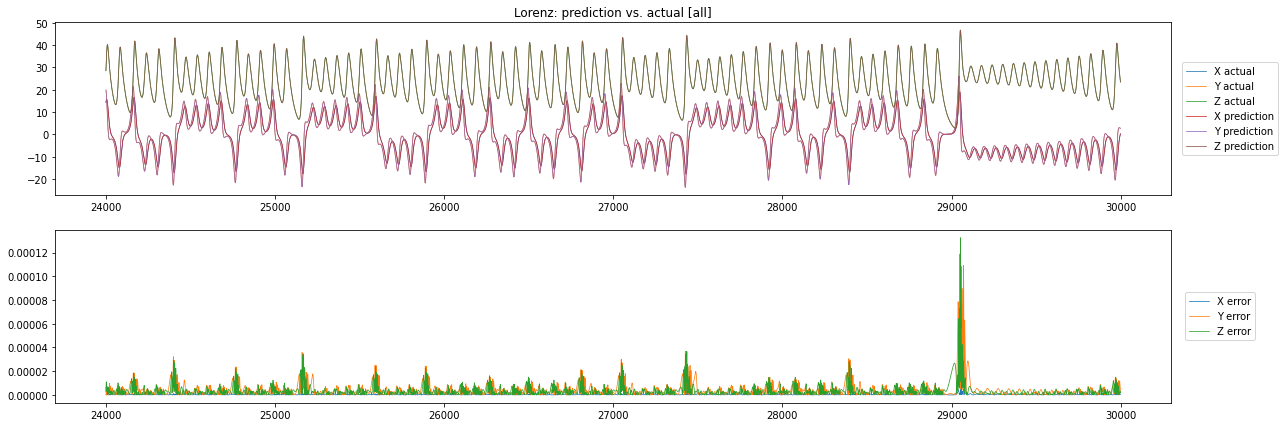

In [121]:
test_out = quadratic_model_300.test_out

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], linewidth=0.75, label="X actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], linewidth=0.75, label="Y actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], linewidth=0.75, label="Z actual")
axs[0].plot(np.arange(test_start,test_end), test_out[:,0], linewidth=0.75, label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,1], linewidth=0.75, label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,2], linewidth=0.75, label="Z prediction")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,0]-test_target[:,0]), linewidth=0.75, label="X error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,1]-test_target[:,1]), linewidth=0.75, label="Y error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,2]-test_target[:,2]), linewidth=0.75, label="Z error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.08,0.5))
axs[0].set_title('Lorenz: prediction vs. actual [all]')
plt.subplots_adjust(hspace=0.2)
plt.show()

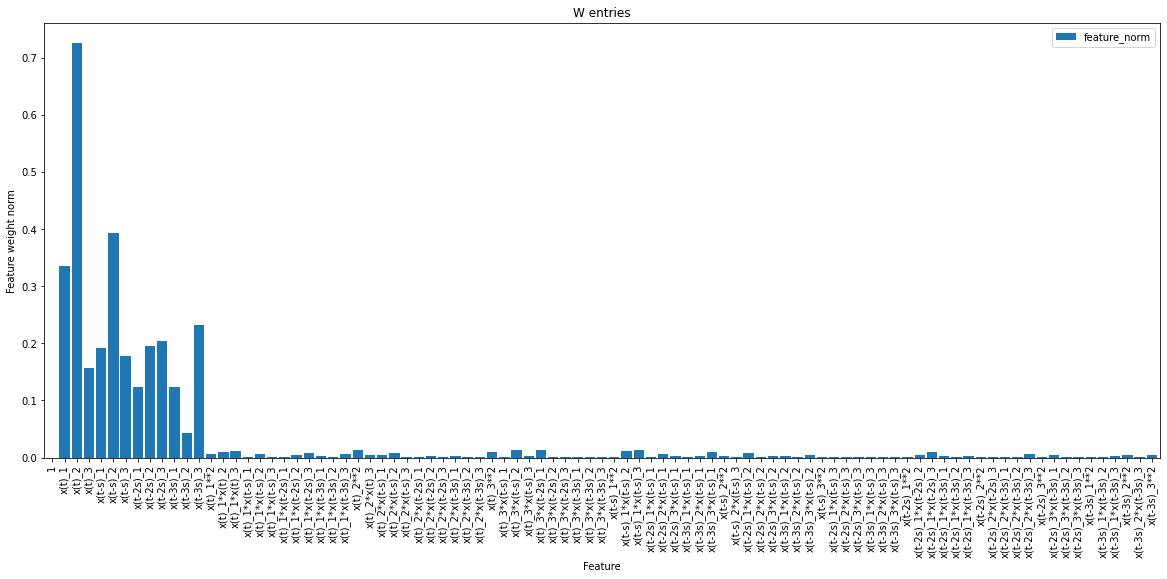

In [124]:
df = pd.DataFrame(quadratic_model_300.w, columns=['x_1','x_2','x_3'])
df['feature'] = symb_state[:,0]
df['feature_type'] = symb_state[:,1]

feature_norms = np.array([np.linalg.norm(x) for x in quadratic_model_300.w])
df_combined = pd.DataFrame(feature_norms, columns=['feature_norm'])
df_combined['feature'] = symb_state[:,0]
df_combined['feature_type'] = symb_state[:,1]

ax = df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Feature weight norm',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df_combined['feature'])
ax.legend()

Linear model on large dataset

In [125]:
model_arr = []
s_grid = [2,3,4,5,6,7,8,10]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
recursive_rmse_arr = []
ctr = 0
total_scens = len(s_grid)*len(reg_grid)
for s in s_grid:
    for r in reg_grid:
        clear_output(wait=True)
        print(f'done: scen {ctr}/{total_scens-1} ({100*ctr/(total_scens-1):.02f}%) |  s={s} r={r}')
        model = NVARModel(30, s, r, None)
        model.train(data, target, train_indices)
        recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        model_arr.append(model)
        ctr += 1
recursive_rmse_arr = np.array(recursive_rmse_arr)
best_recursive_idx = np.argmin(recursive_rmse_arr[~np.isnan(recursive_rmse_arr)])
best_recursive_model = [model_arr[i] for i in range(len(model_arr)) if ~np.isnan(recursive_rmse_arr)[i]][best_recursive_idx]

print(f'best recursive params (linear model) T={T}')
print(f'k  :{best_recursive_model.k}')
print(f's  :{best_recursive_model.s}')
print(f'reg:{best_recursive_model.reg}')

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params (linear model) T=300
k  :30
s  :8
reg:1e-07


In [126]:
linear_model_300 = NVARModel(k=30, s=8, reg=1e-7, nonlinearFunc=None) # k=30 -> 91 model size
linear_model_300.train(data, target, train_indices)
linear_model_300.evaluate(data, target, test_indices)

0.21596725615008647

In [127]:
linear_model_300.w.shape

(91, 3)

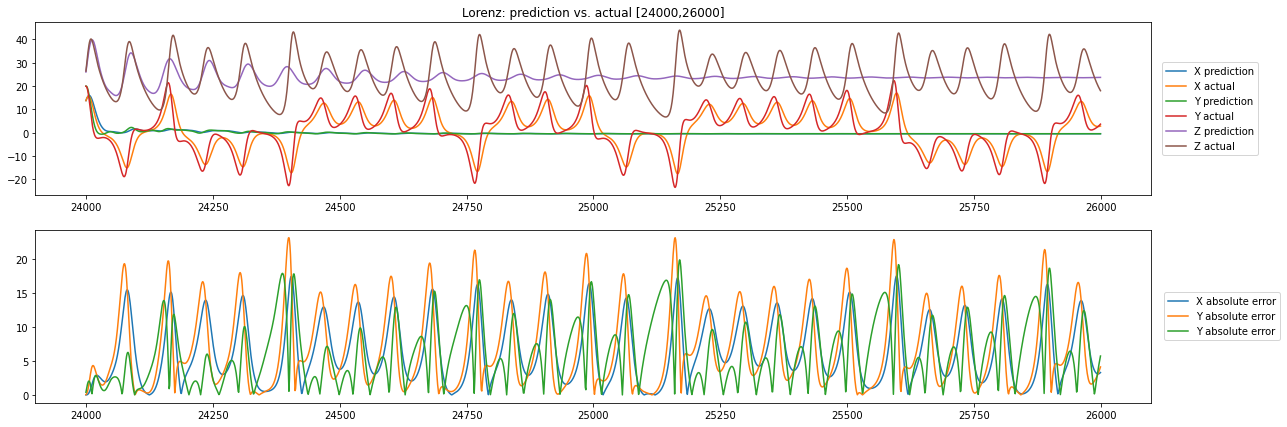

In [128]:
recursive_out = linear_model_300.recursive_predict(data, train_start, train_end, test_end-test_start)
data_end = train_end
# t_forward = test_end-test_start
t_forward = 2000

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:t_forward,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), raw_data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,0]-raw_data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,1]-raw_data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:t_forward,2]-raw_data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

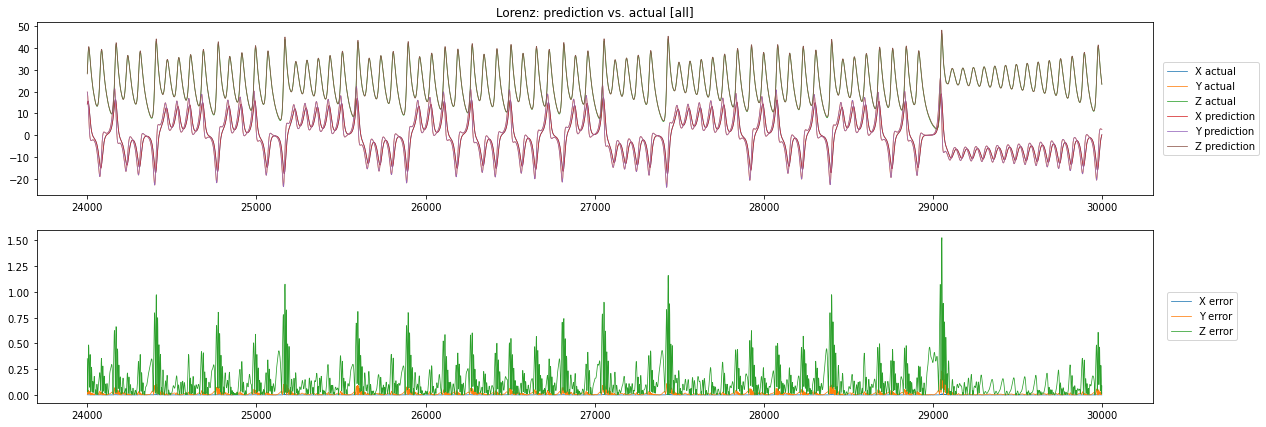

In [131]:
test_out = linear_model_300.test_out

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], linewidth=0.75, label="X actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], linewidth=0.75, label="Y actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], linewidth=0.75, label="Z actual")
axs[0].plot(np.arange(test_start,test_end), test_out[:,0], linewidth=0.75, label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,1], linewidth=0.75, label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,2], linewidth=0.75, label="Z prediction")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,0]-test_target[:,0]), linewidth=0.75, label="X error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,1]-test_target[:,1]), linewidth=0.75, label="Y error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,2]-test_target[:,2]), linewidth=0.75, label="Z error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.08,0.5))
axs[0].set_title('Lorenz: prediction vs. actual [all]')
plt.subplots_adjust(hspace=0.2)
plt.show()

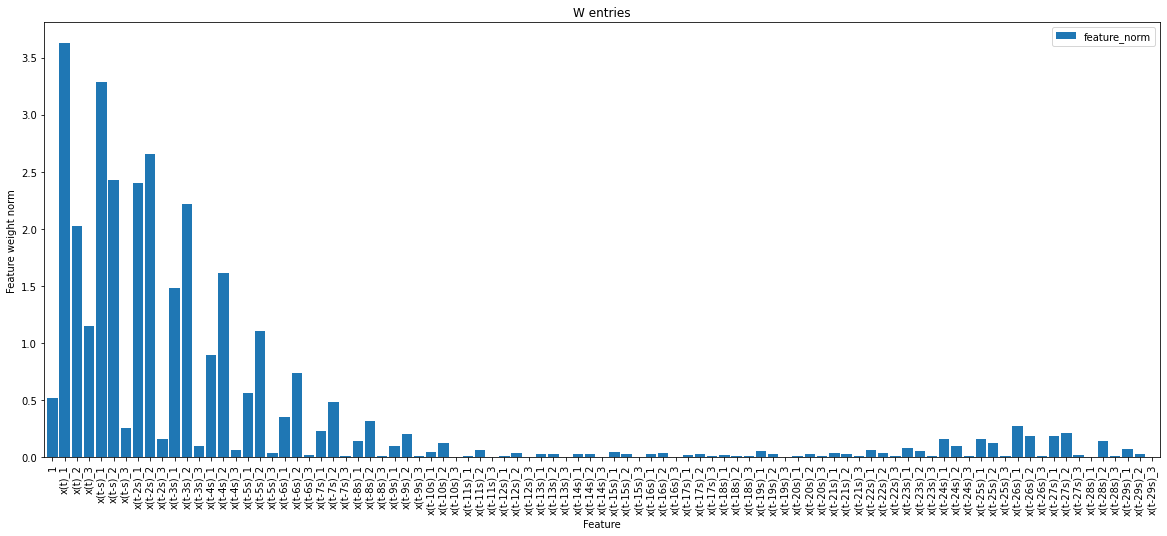

In [132]:
linear_symb_state = get_symbolic_state_labels(
    k=30,
    d=3,
    nonlinearFunc = None,
    extraNonlinearFunc = None
)

df = pd.DataFrame(linear_model_300.w, columns=['x_1','x_2','x_3'])
df['feature'] = linear_symb_state[:,0]
df['feature_type'] = linear_symb_state[:,1]

feature_norms = np.array([np.linalg.norm(x) for x in linear_model_300.w])
df_combined = pd.DataFrame(feature_norms, columns=['feature_norm'])
df_combined['feature'] = linear_symb_state[:,0]
df_combined['feature_type'] = linear_symb_state[:,1]

ax = df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Feature weight norm',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df_combined['feature'])
ax.legend()

In [133]:
ndf_quad_100 = get_norm_df(symb_state, quadratic_model_100)
ndf_quad_300 = get_norm_df(symb_state, quadratic_model_300)
ndf_linear_300 = get_norm_df(linear_symb_state, linear_model_300)

In [134]:
ndf_comb = pd.concat([ndf_quad_100['total'], ndf_quad_300['total'], ndf_linear_300['total']], axis=1)
ndf_comb = ndf_comb.set_axis(['quadratic_100', 'quadratic_300', 'linear_300'], axis=1)
ndf_comb.reindex(['bias','linear','nonlinear','extra-nonlinear','total'])

,quadratic_100,quadratic_300,linear_300
bias,7.441597e-10,2.513355e-09,0.271246
linear,9.841273e-01,1.051644e+00,61.765709
nonlinear,1.315209e-03,1.981488e-03,NaN
extra-nonlinear,NaN,NaN,NaN
total,9.854425e-01,1.053625e+00,62.036955


In [136]:
df_combined_quad_300

,feature_norm,feature,feature_type
0,0.000050,1,bias
1,0.335260,x(t)_1,linear
2,0.724782,x(t)_2,linear
3,0.156500,x(t)_3,linear
4,0.191083,x(t-s)_1,linear
...,...,...,...
86,0.000687,x(t-3s)_1*x(t-3s)_2,nonlinear
87,0.002918,x(t-3s)_1*x(t-3s)_3,nonlinear
88,0.003827,x(t-3s)_2**2,nonlinear
89,0.000301,x(t-3s)_2*x(t-3s)_3,nonlinear


In [140]:
feature_norms_quad_100 = np.array([np.linalg.norm(x) for x in quadratic_model_100.w])
df_combined_quad_100 = pd.DataFrame(feature_norms_quad_100, columns=['feature_norm'])
df_combined_quad_100['feature'] = symb_state[:,0]
df_combined_quad_100['feature_type'] = symb_state[:,1]

feature_norms_quad_300 = np.array([np.linalg.norm(x) for x in quadratic_model_300.w])
df_combined_quad_300 = pd.DataFrame(feature_norms_quad_300, columns=['feature_norm'])
df_combined_quad_300['feature'] = symb_state[:,0]
df_combined_quad_300['feature_type'] = symb_state[:,1]

df_diff = df_combined_quad_300.copy(deep=True)
df_diff['feature_norm'] = df_diff['feature_norm'] - df_combined_quad_100['feature_norm']

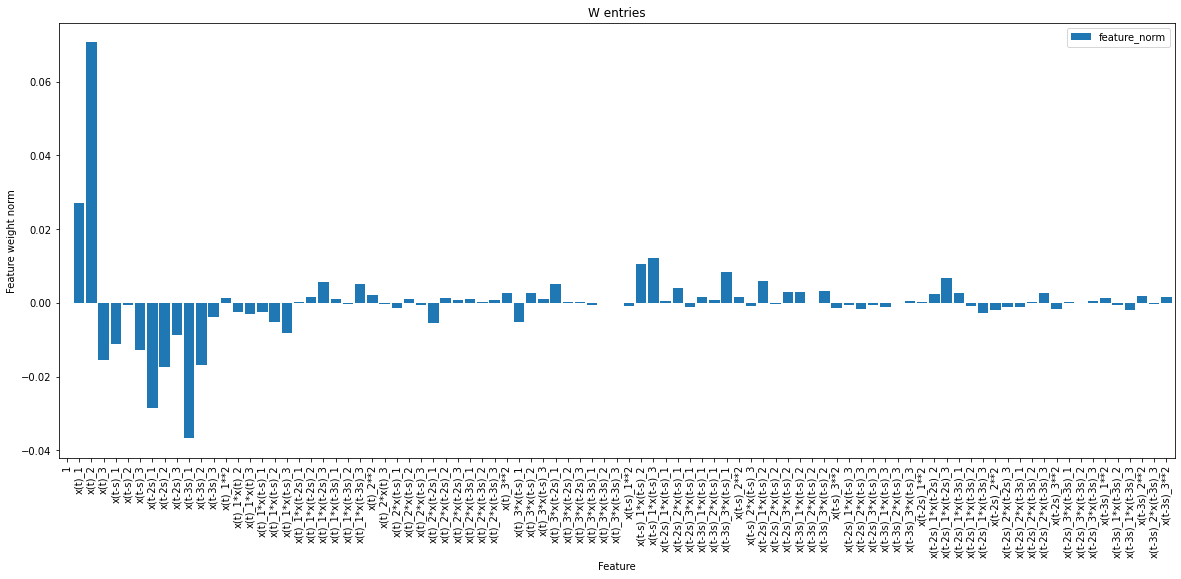

In [141]:
ax = df_diff.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Feature weight norm',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df_diff['feature'])
ax.legend()

Hybrid NVAR

Work in progress...